Example notebook training a flow on samples from a known distribution, then using rejection sampling to generate new samples

In [1]:
import os
import sys
import argparse
import logging
import torch
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from scipy.stats import multivariate_normal

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [4]:
from nnest import NestedSampler, MCMCSampler
from nnest.trainer import Trainer
from nnest.likelihoods import *
from nnest.priors import *
from nnest.distributions import GeneralisedNormal

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
def test(like, prior, model, num_samples=1000, nested_fraction=0.01):
    np.random.seed(0)
    init_samples, loglstar = like.uniform_sample(prior, 1000, nested_fraction)
    model.train(init_samples, jitter=0.001, max_iters=2000)
    model.plot_samples(init_samples, plot_synthetic=False)
    sampler = MCMCSampler(like.x_dim, like, prior=prior, trainer=model, log_level=logging.INFO)
    samples = np.empty((num_samples, like.x_dim))
    ncalls = np.zeros(num_samples)
    for i in range(samples.shape[0]):
        results = sampler._rejection_flow_sample(init_samples, loglstar, cache=True)
        sample, derived_sample, loglike, ncall = results
        samples[i, :] = sample[0, :]
        ncalls[i] = ncall
    print(np.mean(ncalls))
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    flat_samples = samples.reshape((-1, like.x_dim))
    ax[0].scatter(flat_samples[:,0], flat_samples[:,1], c='r', s=5, alpha=0.5)
    plt.show()

In [7]:
like = Gaussian(2, 0.9)
prior = UniformPrior(2, -5, 5)

In [8]:
#model = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
#test(like, prior, model)

In [9]:
#model = Trainer(like.x_dim, hidden_dim=64, num_blocks=5, flow='nvp', learning_rate=0.001)
#test(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

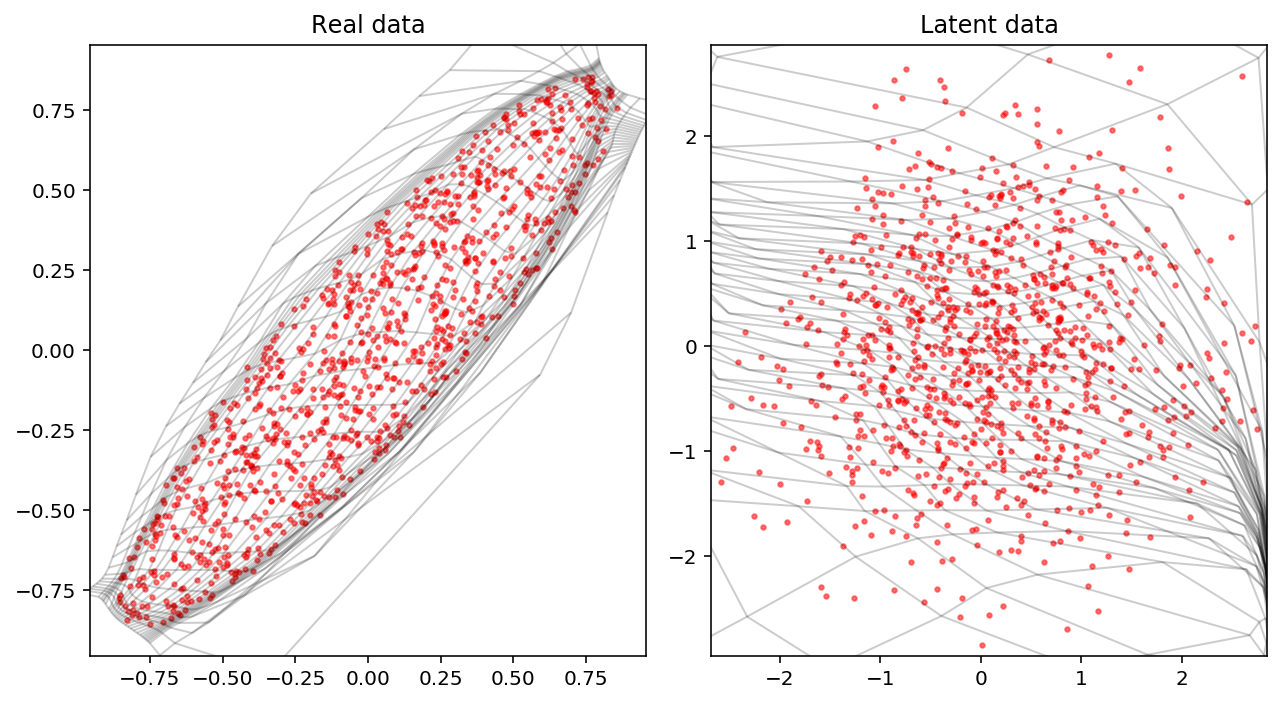

Creating directory for new run logs/test/run267
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
1.397


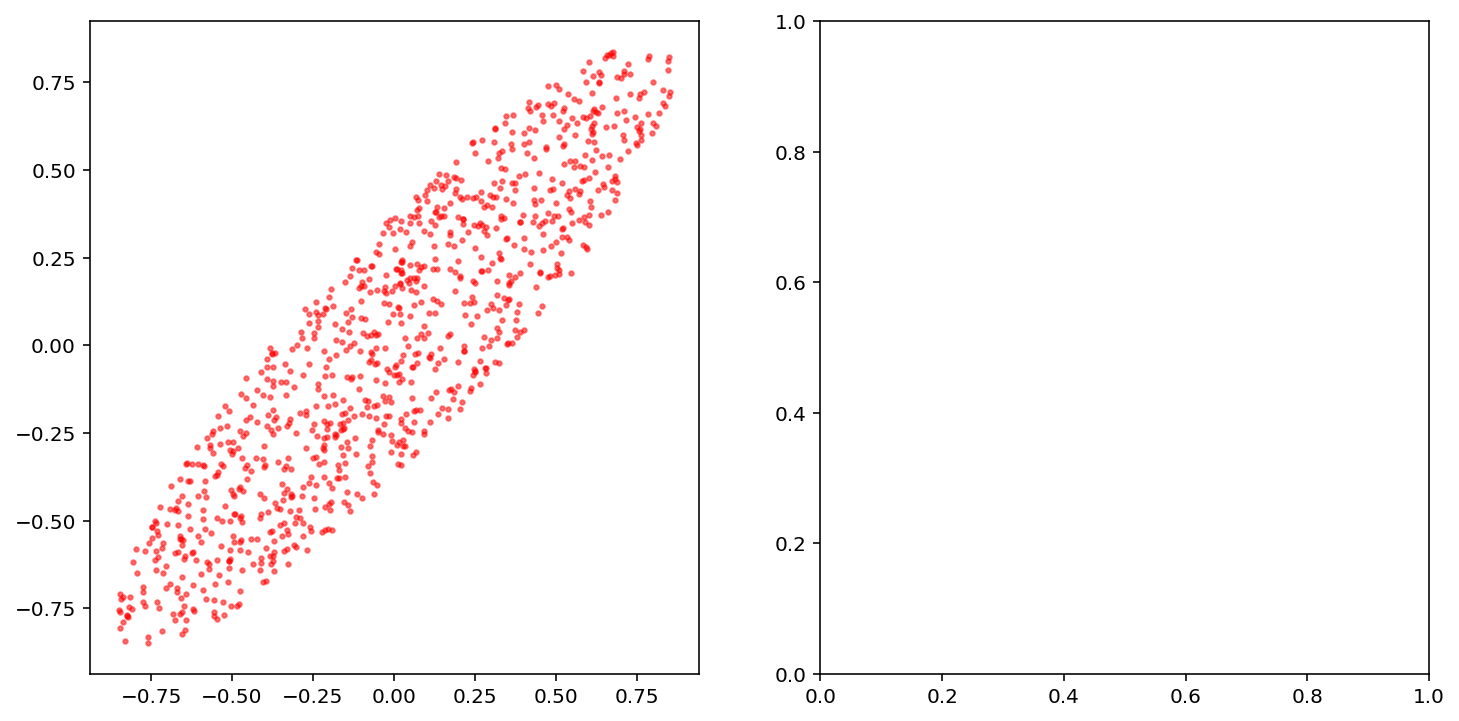

In [10]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test(like, prior, model)

In [11]:
like = Himmelblau(2)
prior = UniformPrior(2, -5, 5)

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0010]
[nnest.trainer] [INFO] Epoch [1] train loss [0.1008] validation loss [0.1018]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0578] validation loss [0.0594]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0502] validation loss [0.0512]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0487] validation loss [0.0495]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0485] validation loss [0.0491]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0485] validation loss [0.0491]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0485] validation loss [0.0491]
[nnest.trainer] [INFO] Epoch [611] ran out of patience
[nnest.trainer] [INFO] Best epoch [561] validation loss [0.0491

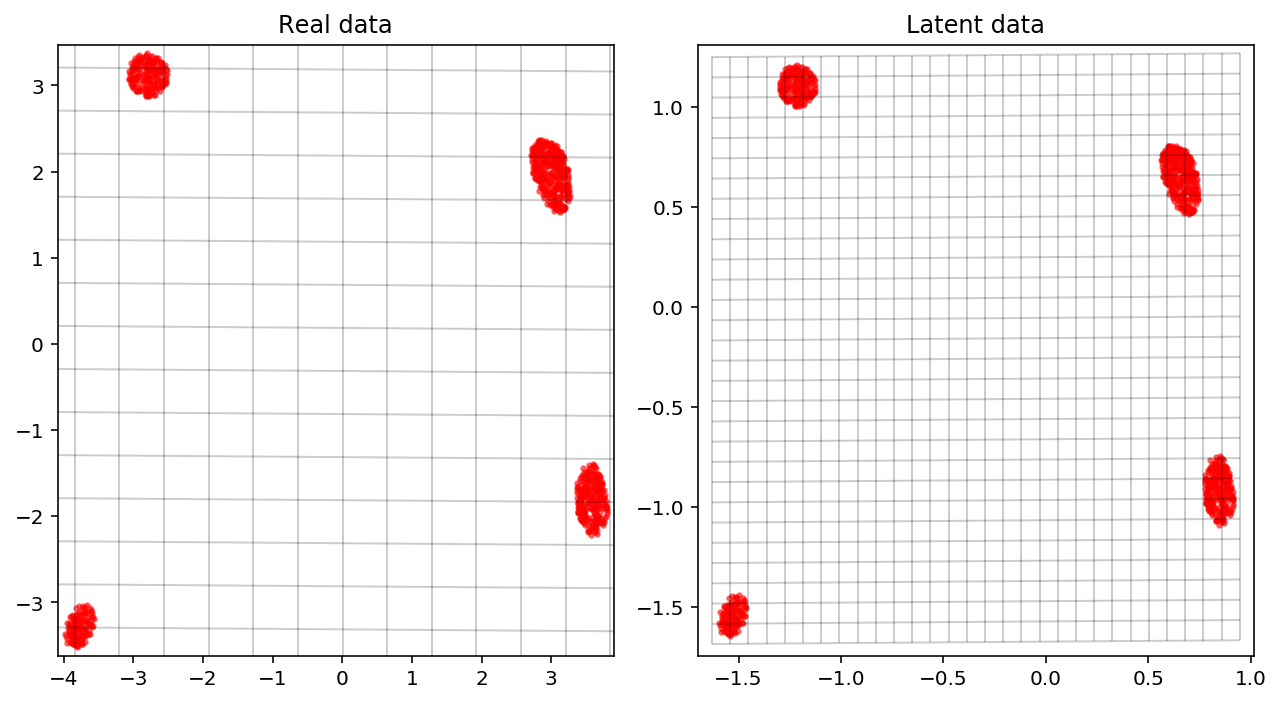

Creating directory for new run logs/test/run271
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
95.63


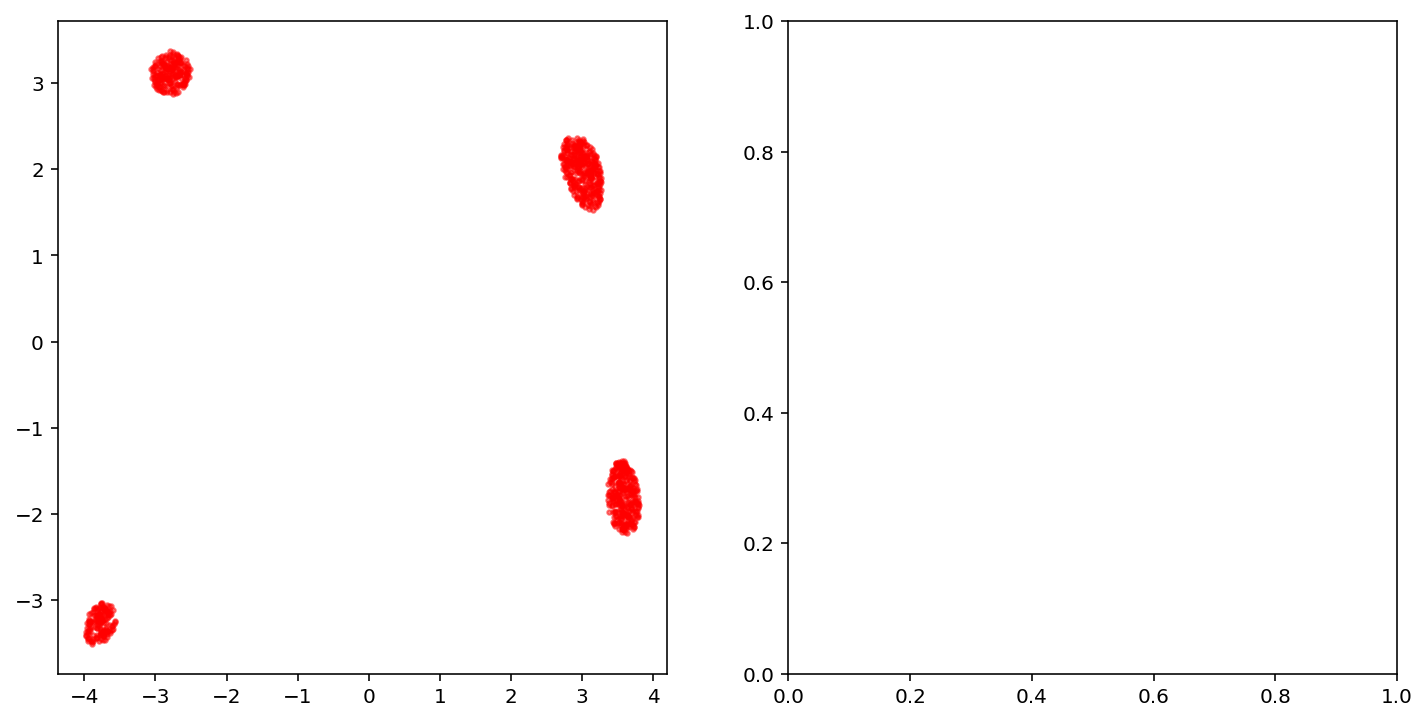

In [12]:
model = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
test(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedNVP(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
        (translate_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=2, bias=True)
      

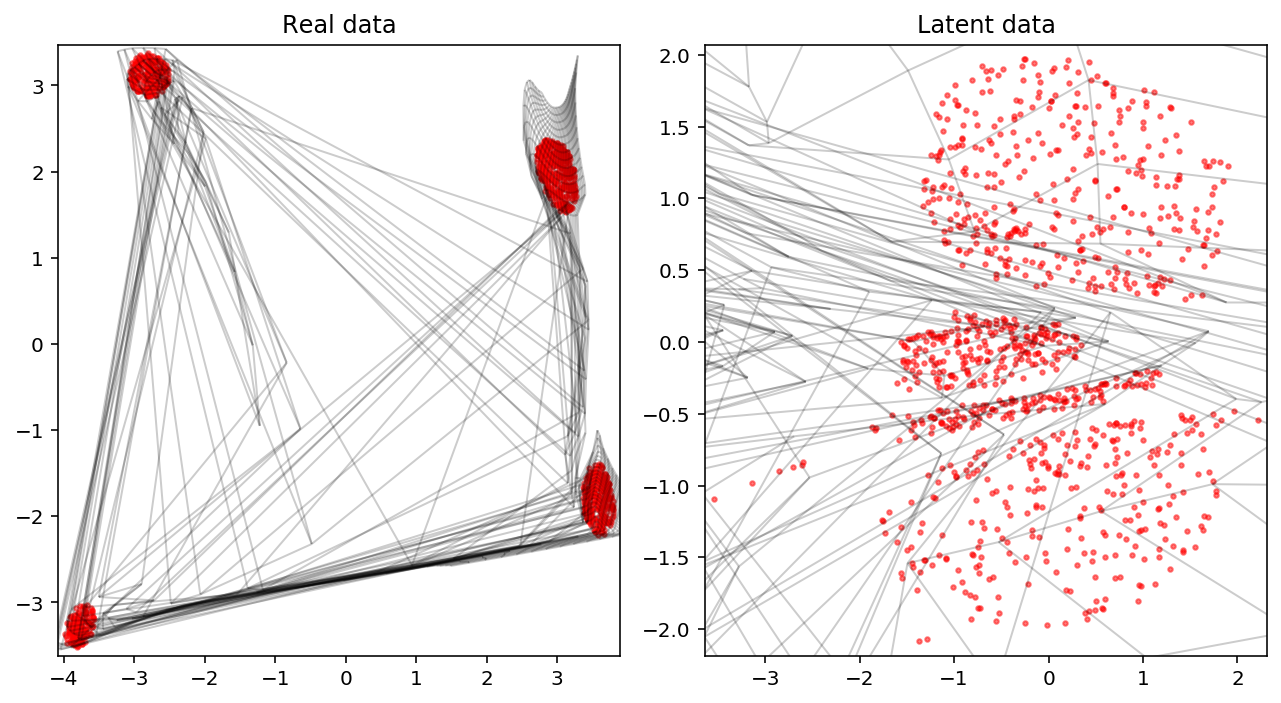

Creating directory for new run logs/test/run275
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
5.846


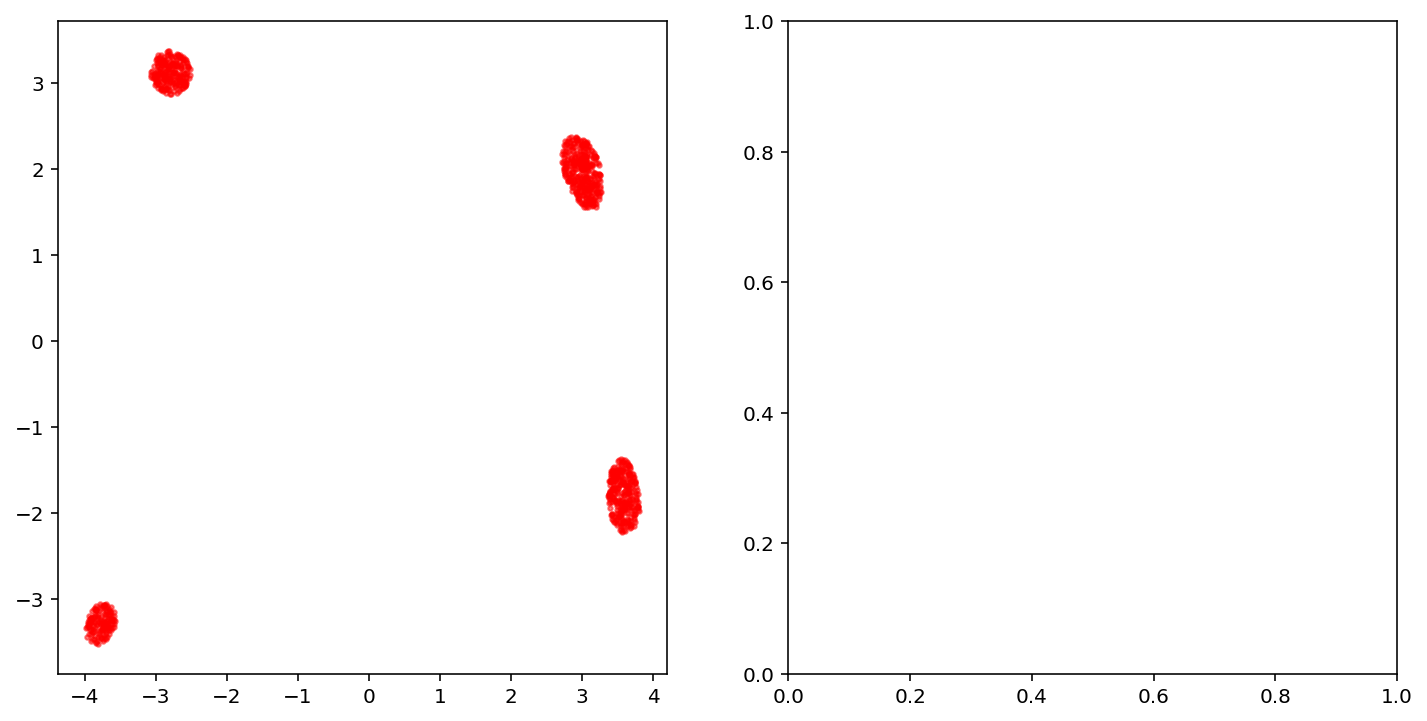

In [13]:
model = Trainer(like.x_dim, hidden_dim=64, num_blocks=5, flow='nvp', learning_rate=0.001)
test(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

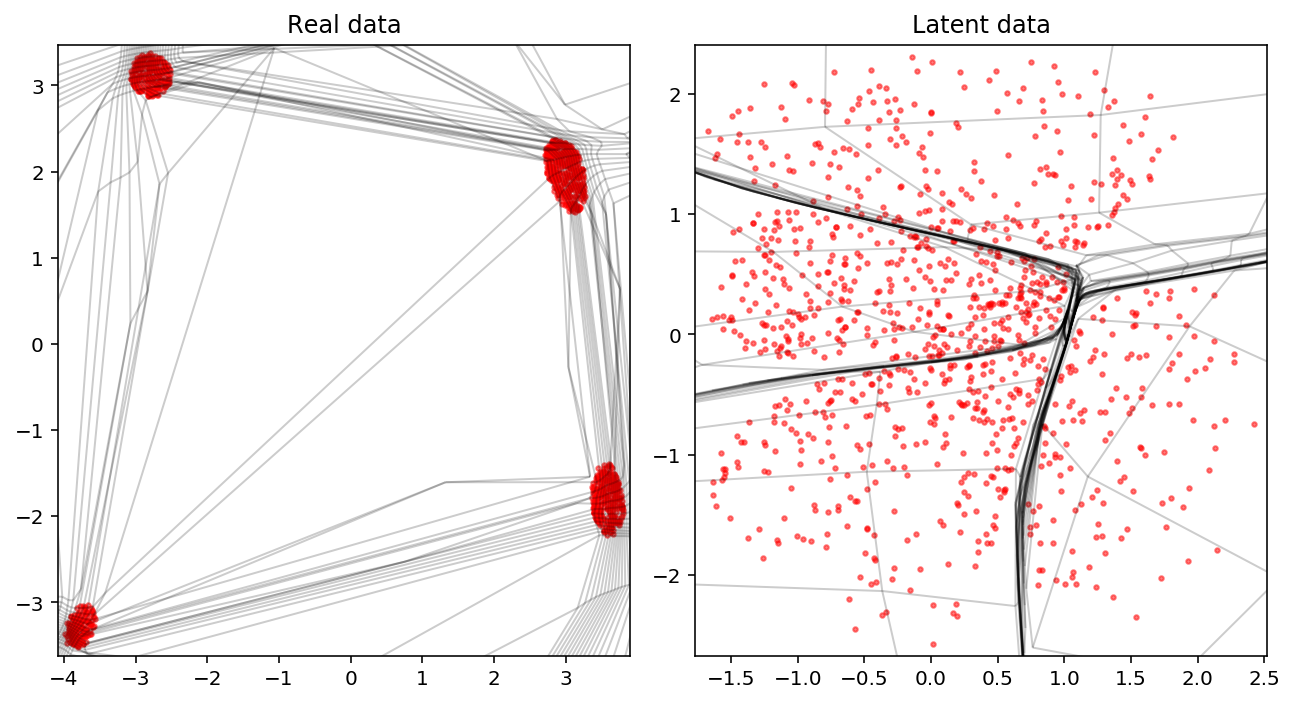

Creating directory for new run logs/test/run277
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
4.577


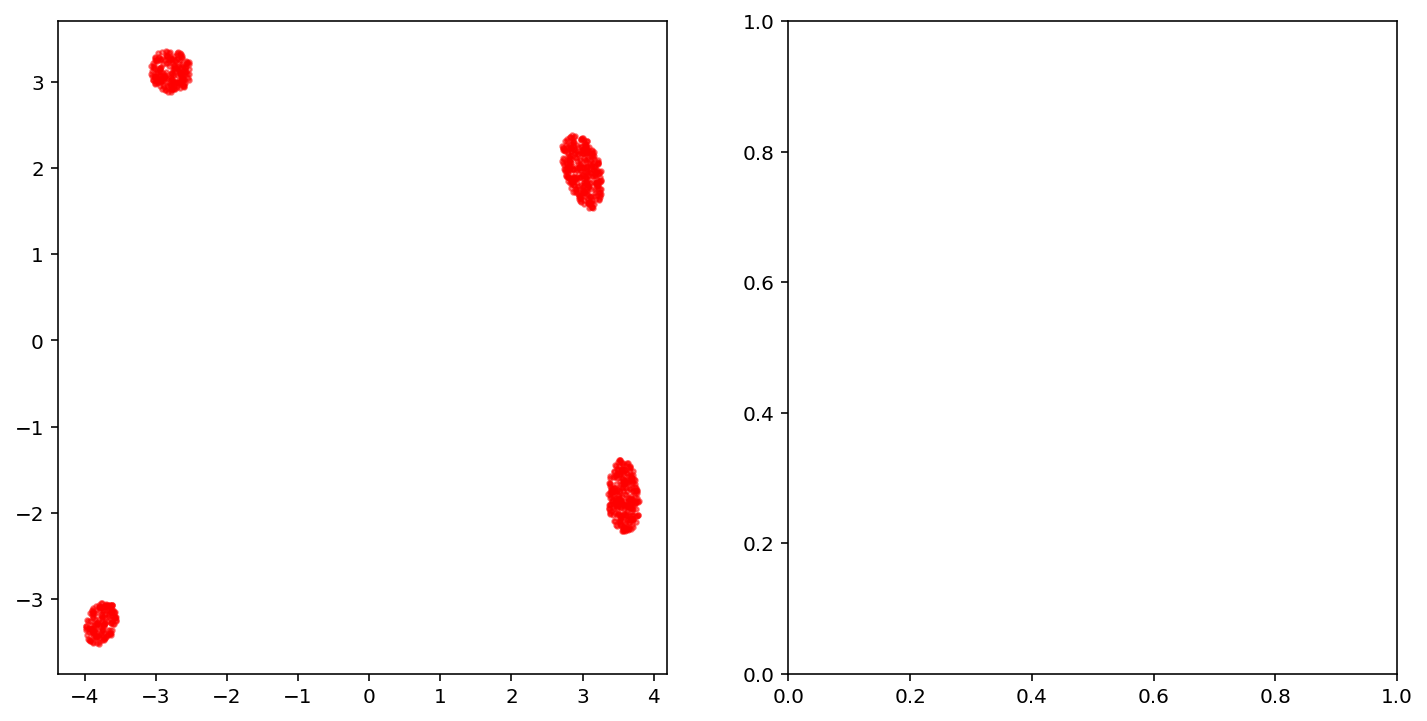

In [14]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test(like, prior, model)

In [15]:
like = Rosenbrock(2)
prior = UniformPrior(2, -2, 12)

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0010]
[nnest.trainer] [INFO] Epoch [1] train loss [0.1008] validation loss [0.1048]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0389] validation loss [0.0387]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0351] validation loss [0.0347]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0347] validation loss [0.0342]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0345] validation loss [0.0341]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0345] validation loss [0.0340]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0344] validation loss [0.0339]
[nnest.trainer] [INFO] Epoch [700] train loss [0.0344] validation loss [0.0339]
[nnest.trainer] [INFO] Epoch [800] tra

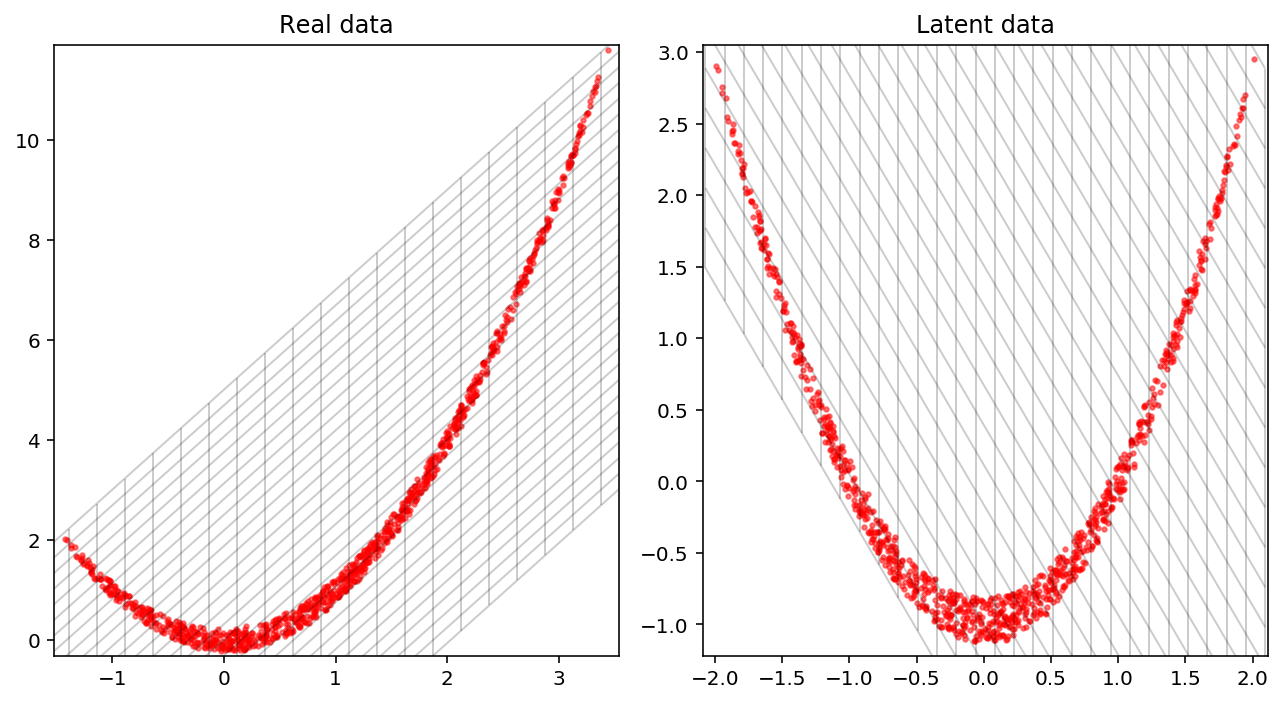

Creating directory for new run logs/test/run287
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
32.824


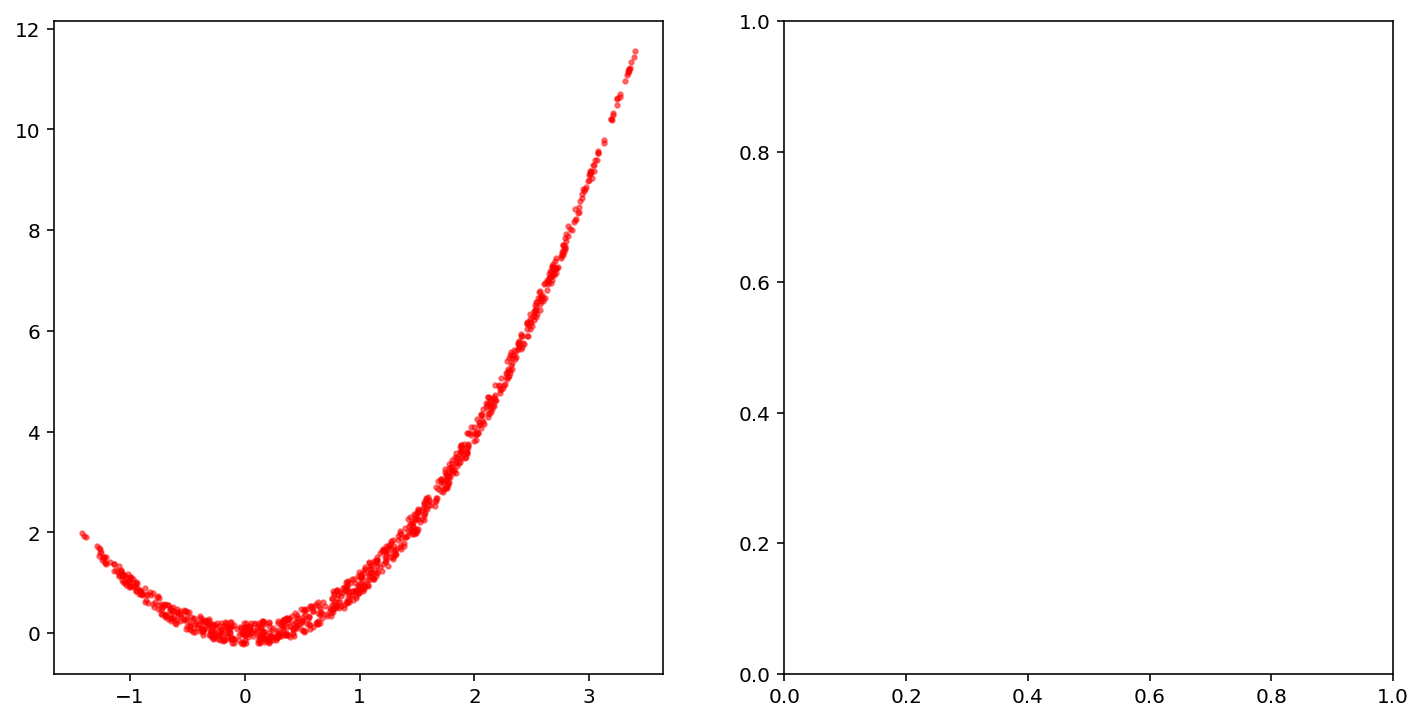

In [16]:
model = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
test(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedNVP(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
        (translate_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=2, bias=True)
      

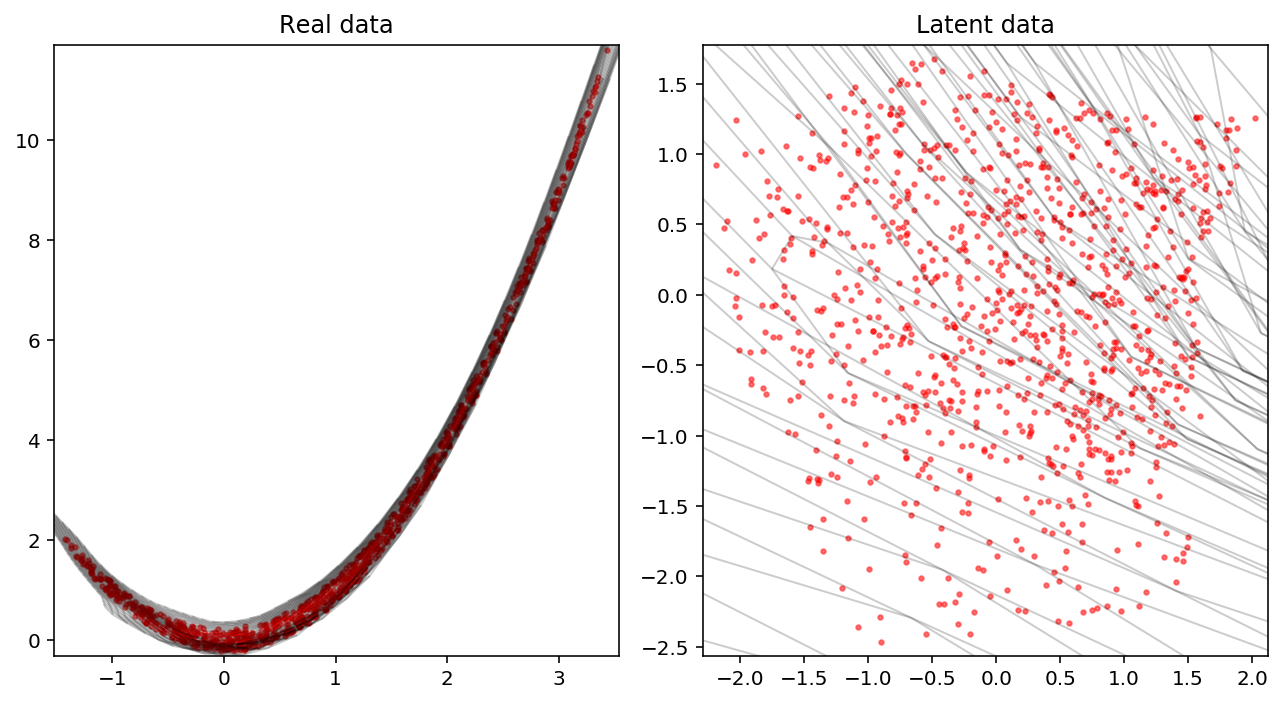

Creating directory for new run logs/test/run289
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
1.79


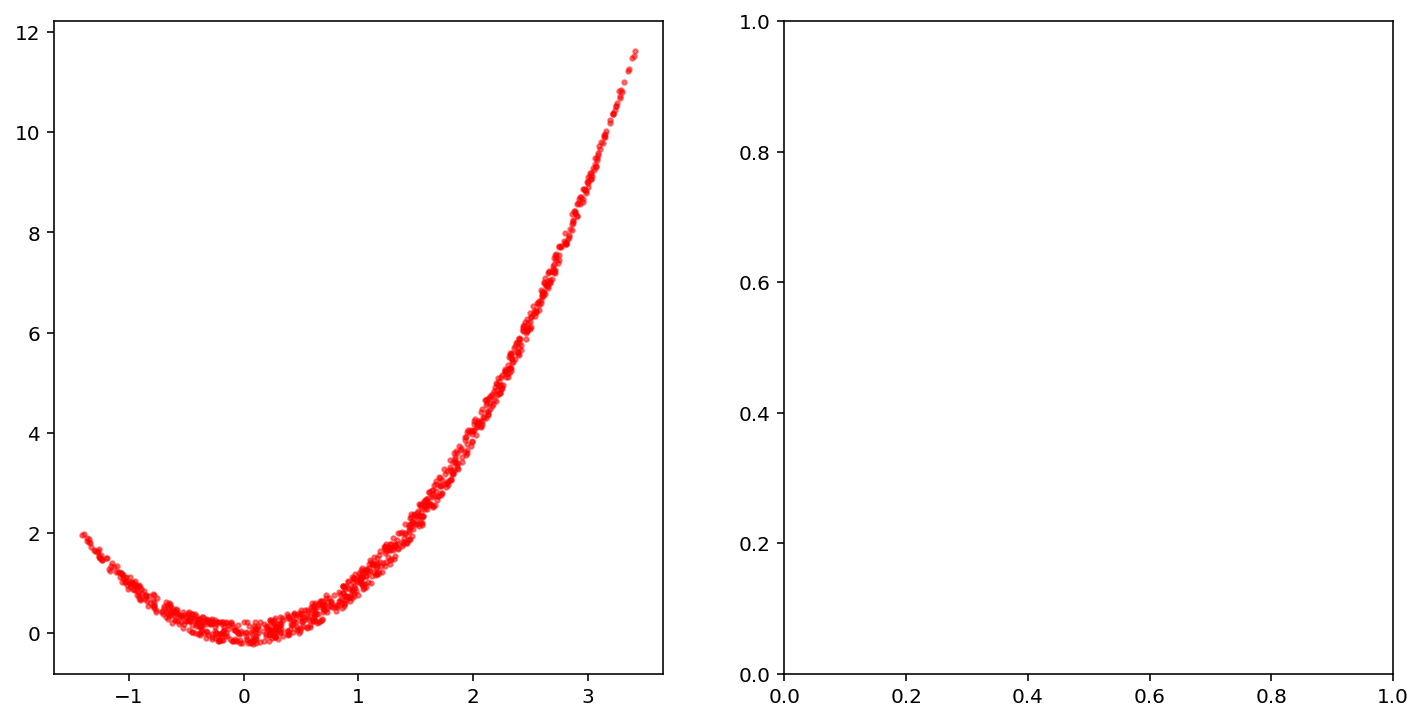

In [17]:
model = Trainer(like.x_dim, hidden_dim=64, num_blocks=5, flow='nvp', learning_rate=0.001)
test(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

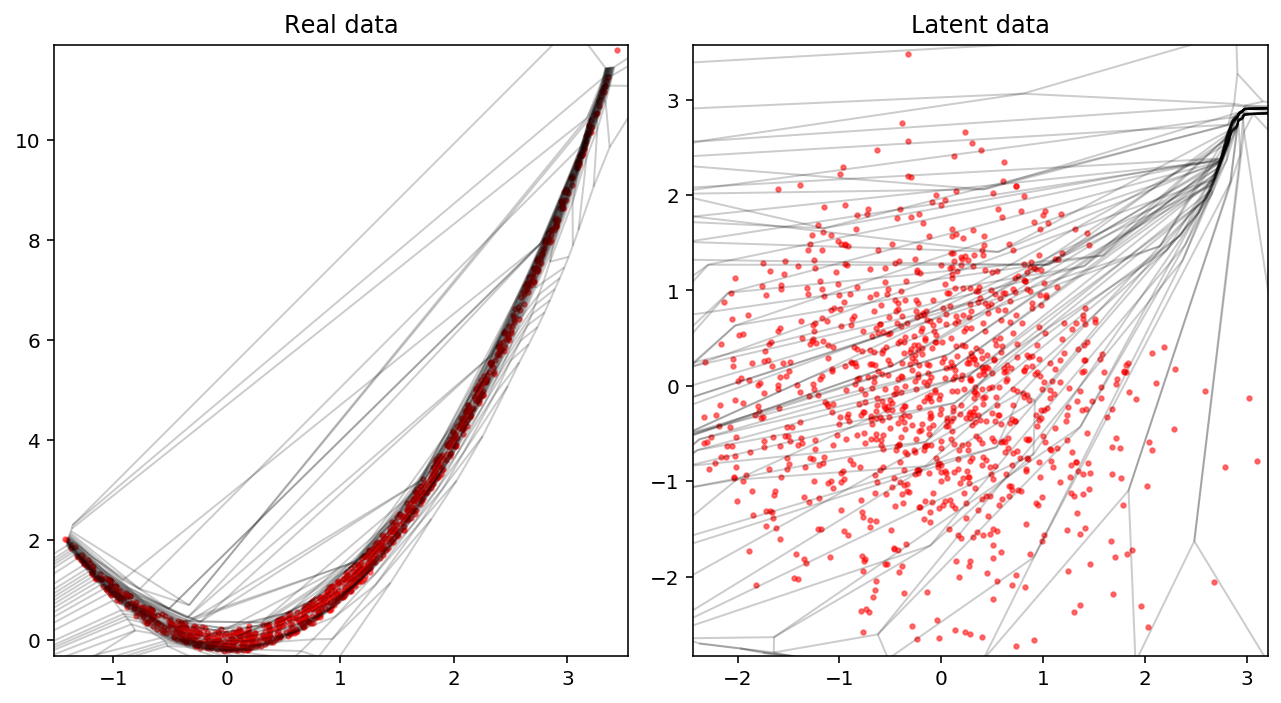

Creating directory for new run logs/test/run292
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
2.303


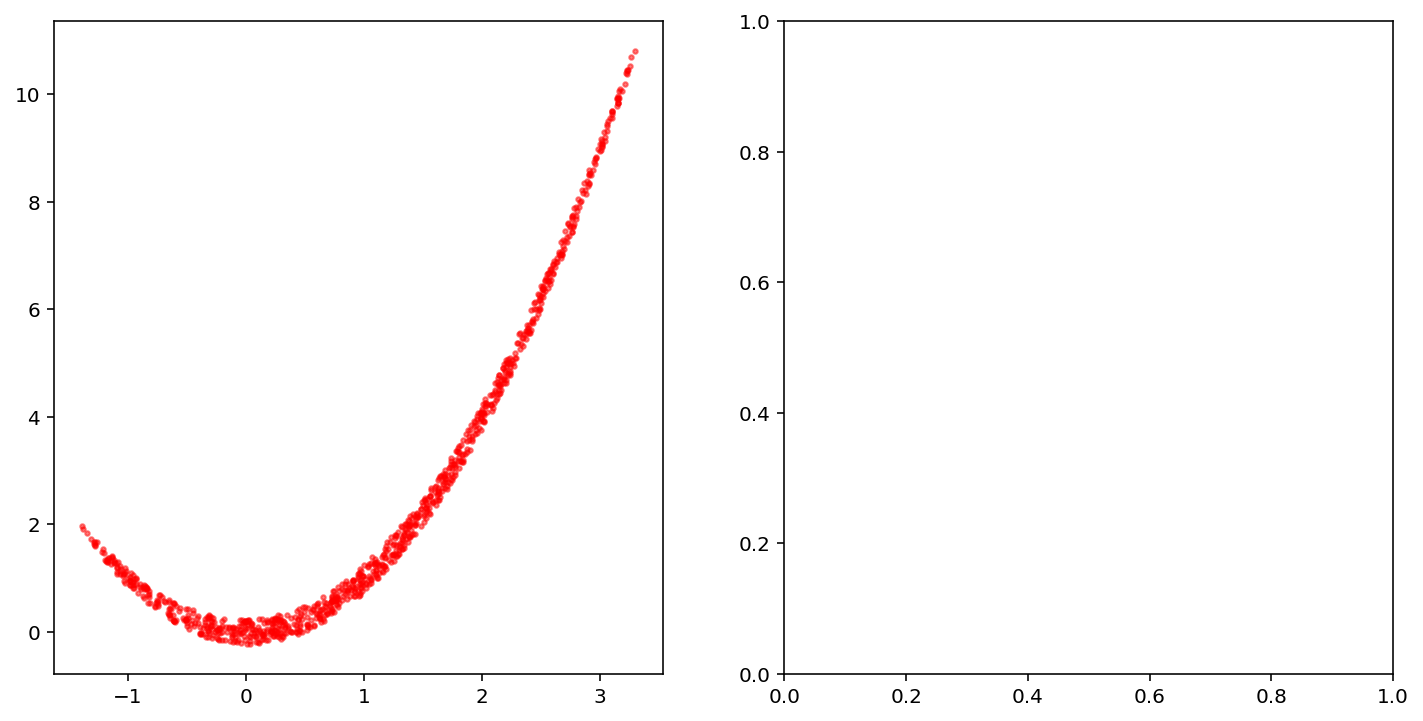

In [18]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test(like, prior, model)

In [19]:
prior = UniformPrior(2, -15, 15)
like = Eggbox(2)

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0010]
[nnest.trainer] [INFO] Epoch [1] train loss [0.8337] validation loss [0.8680]
[nnest.trainer] [INFO] Epoch [100] train loss [0.3267] validation loss [0.3402]
[nnest.trainer] [INFO] Epoch [200] train loss [0.1713] validation loss [0.1776]
[nnest.trainer] [INFO] Epoch [300] train loss [0.1140] validation loss [0.1173]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0899] validation loss [0.0919]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0793] validation loss [0.0806]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0748] validation loss [0.0757]
[nnest.trainer] [INFO] Epoch [700] train loss [0.0730] validation loss [0.0737]
[nnest.trainer] [INFO] Epoch [800] tra

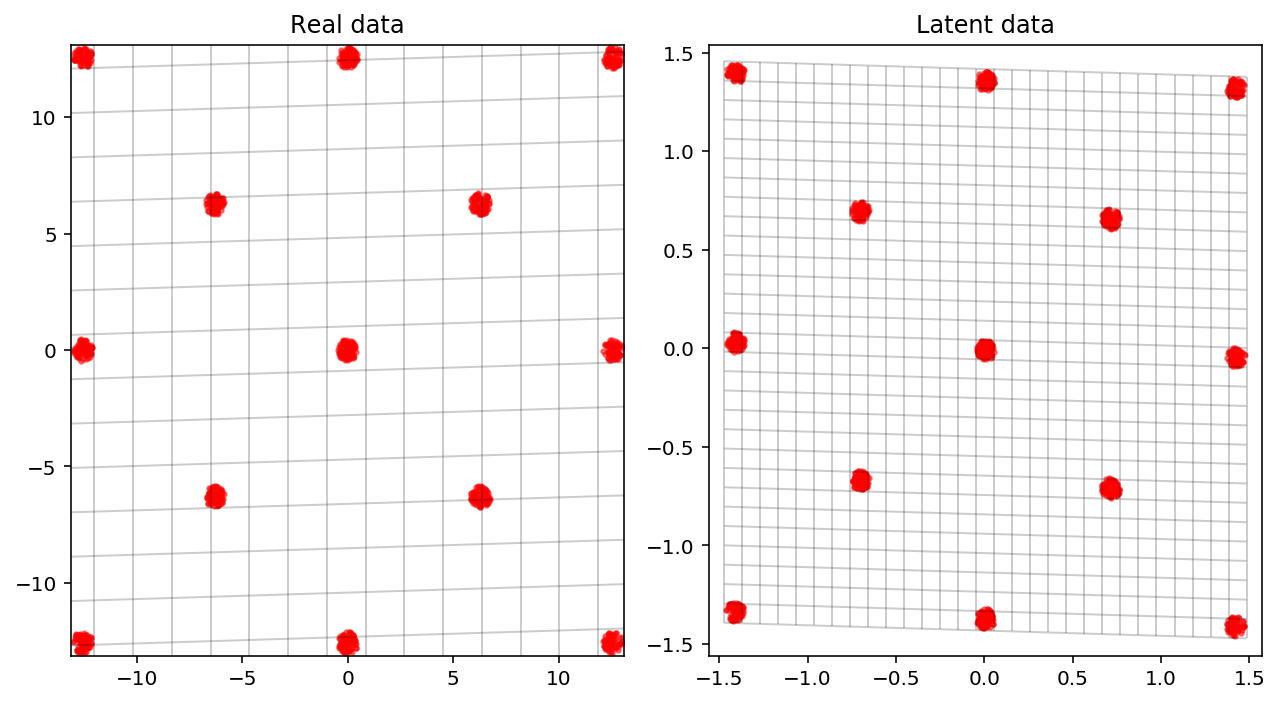

Creating directory for new run logs/test/run294
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
98.093


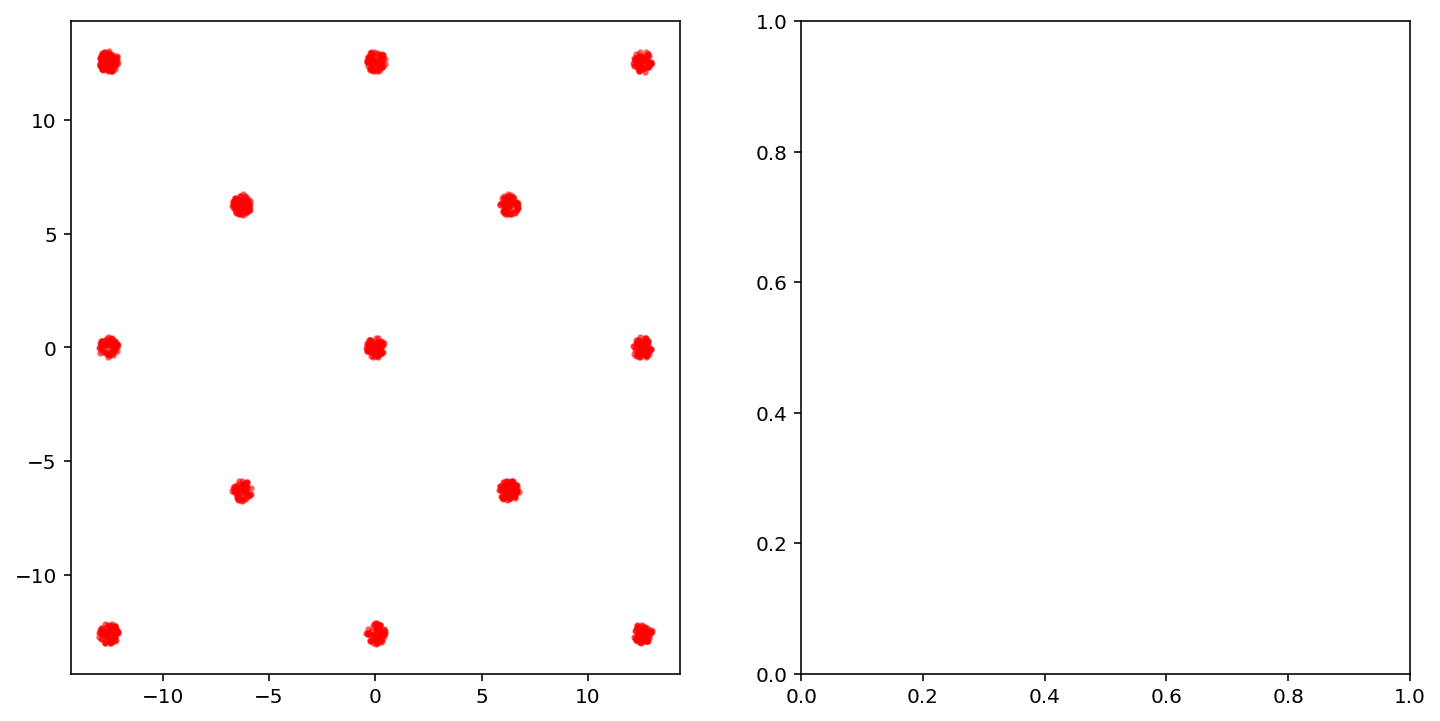

In [20]:
model = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
test(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedNVP(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
        (translate_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=2, bias=True)
      

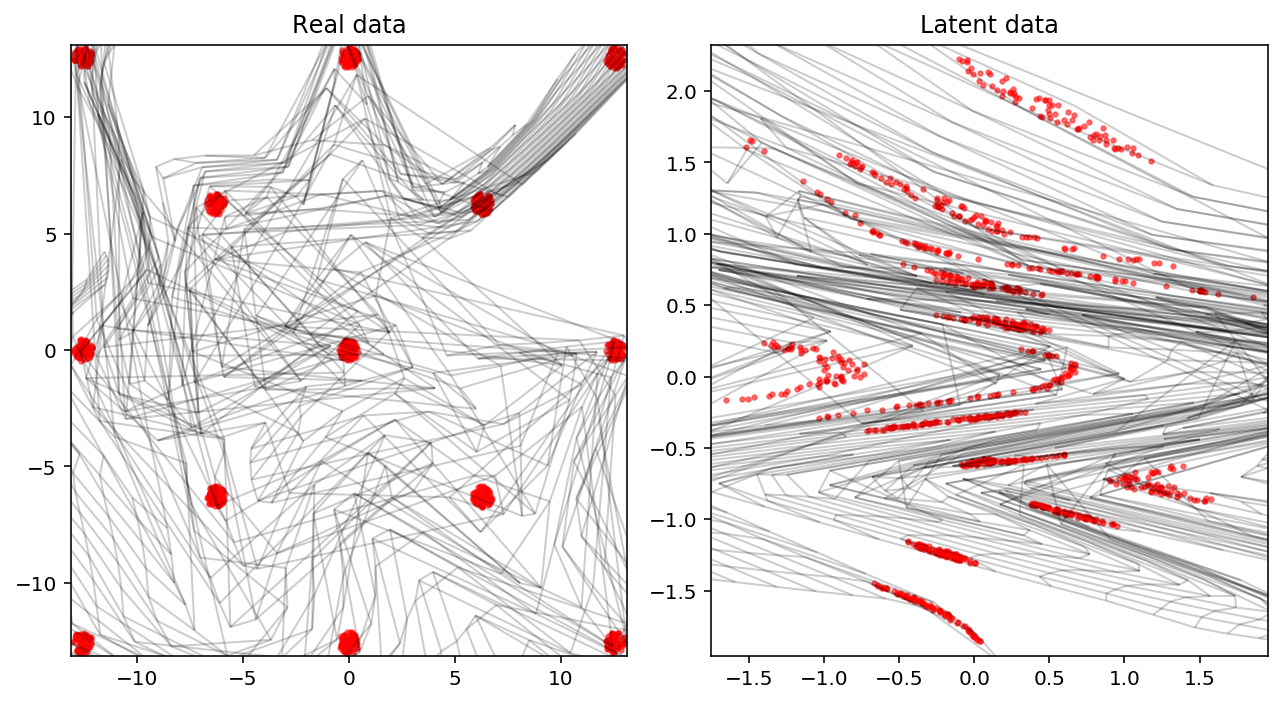

Creating directory for new run logs/test/run296
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
47.168


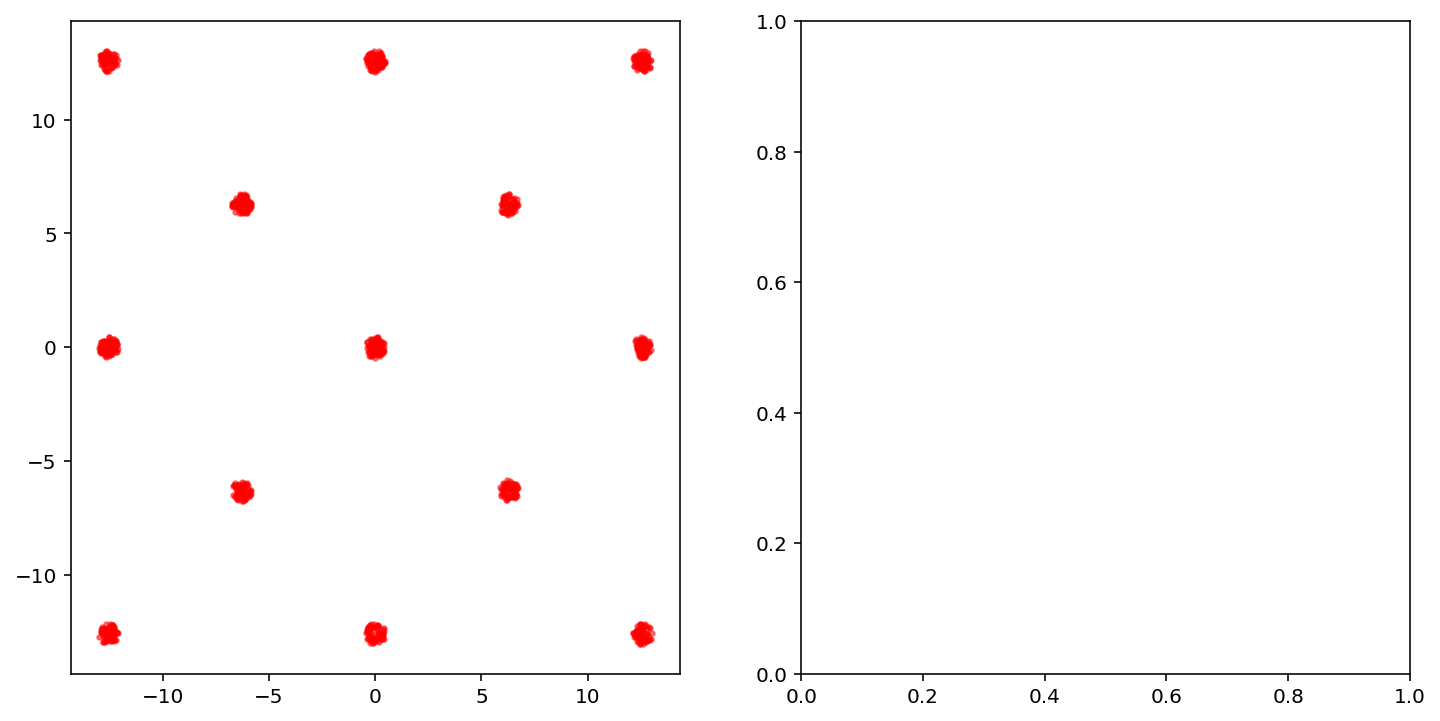

In [21]:
model = Trainer(like.x_dim, hidden_dim=64, num_blocks=5, flow='nvp', learning_rate=0.001)
test(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

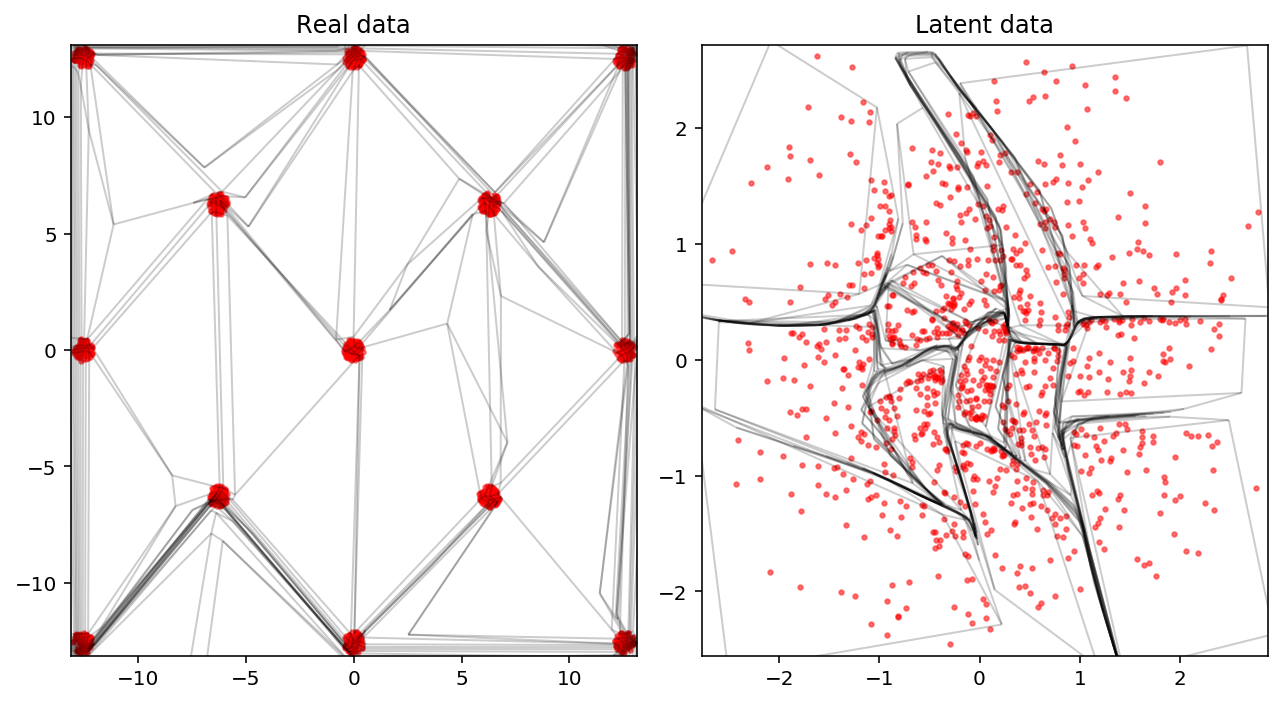

Creating directory for new run logs/test/run308
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
12.989


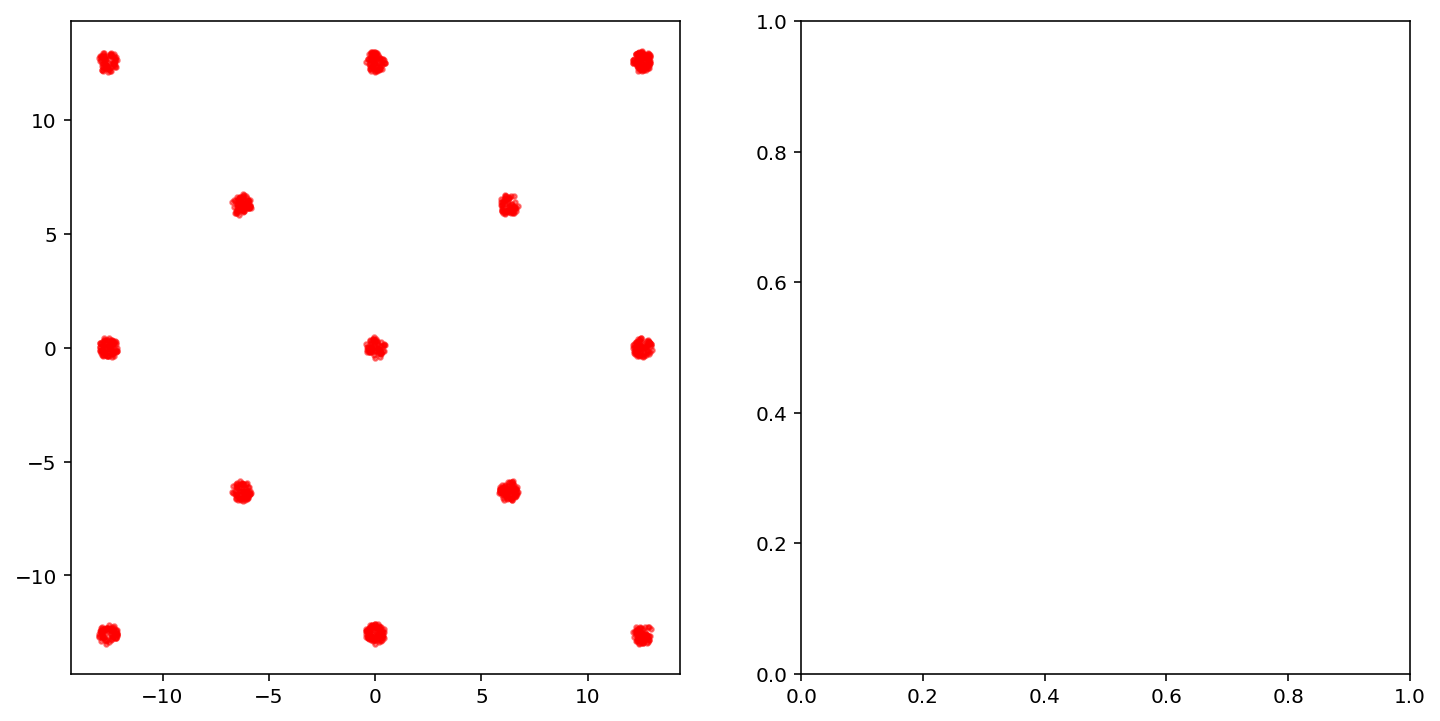

In [22]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test(like, prior, model)

In [23]:
prior = UniformPrior(2, [-7, -3], [7, 3])
like = DoubleGaussianShell(2, centers=[[-4.0, 0.0], [4.0, 0.0]])

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0010]
[nnest.trainer] [INFO] Epoch [1] train loss [0.1206] validation loss [0.1180]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0661] validation loss [0.0657]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0519] validation loss [0.0519]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0478] validation loss [0.0479]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0467] validation loss [0.0468]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0465] validation loss [0.0466]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0464] validation loss [0.0466]
[nnest.trainer] [INFO] Epoch [635] ran out of patience
[nnest.trainer] [INFO] Best epoch [585] validation loss [0.0466

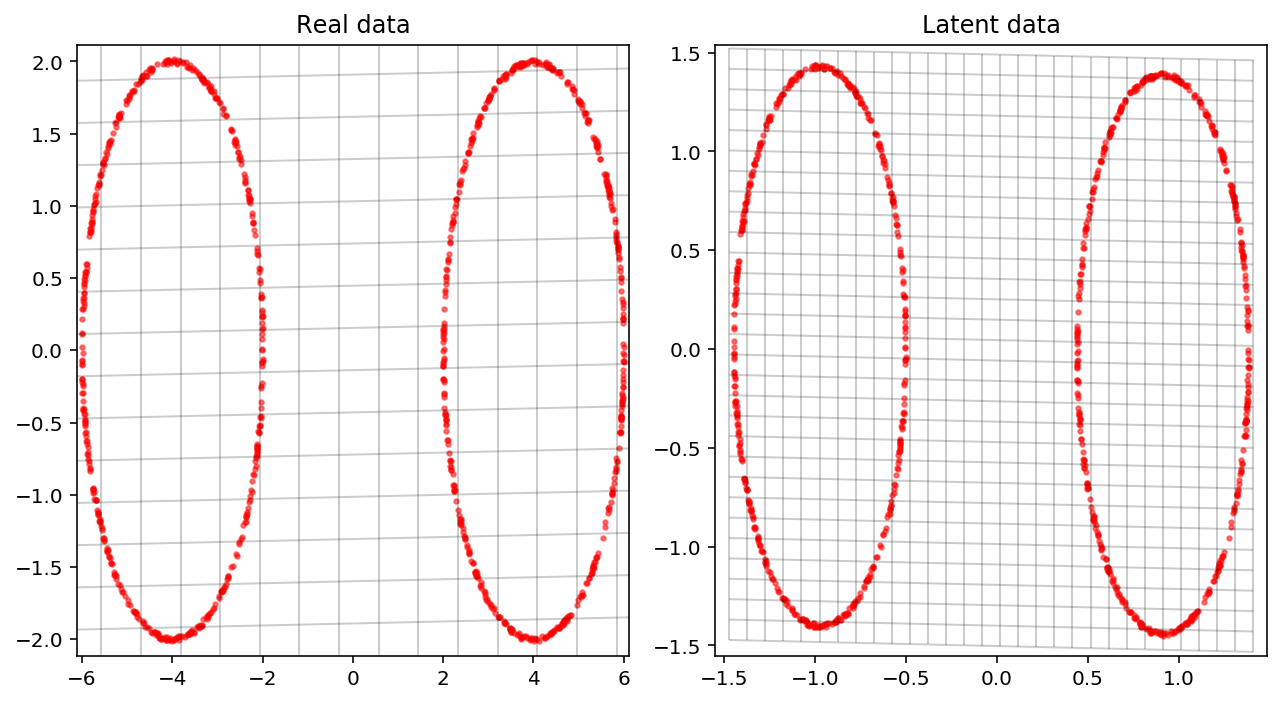

Creating directory for new run logs/test/run334
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
83.585


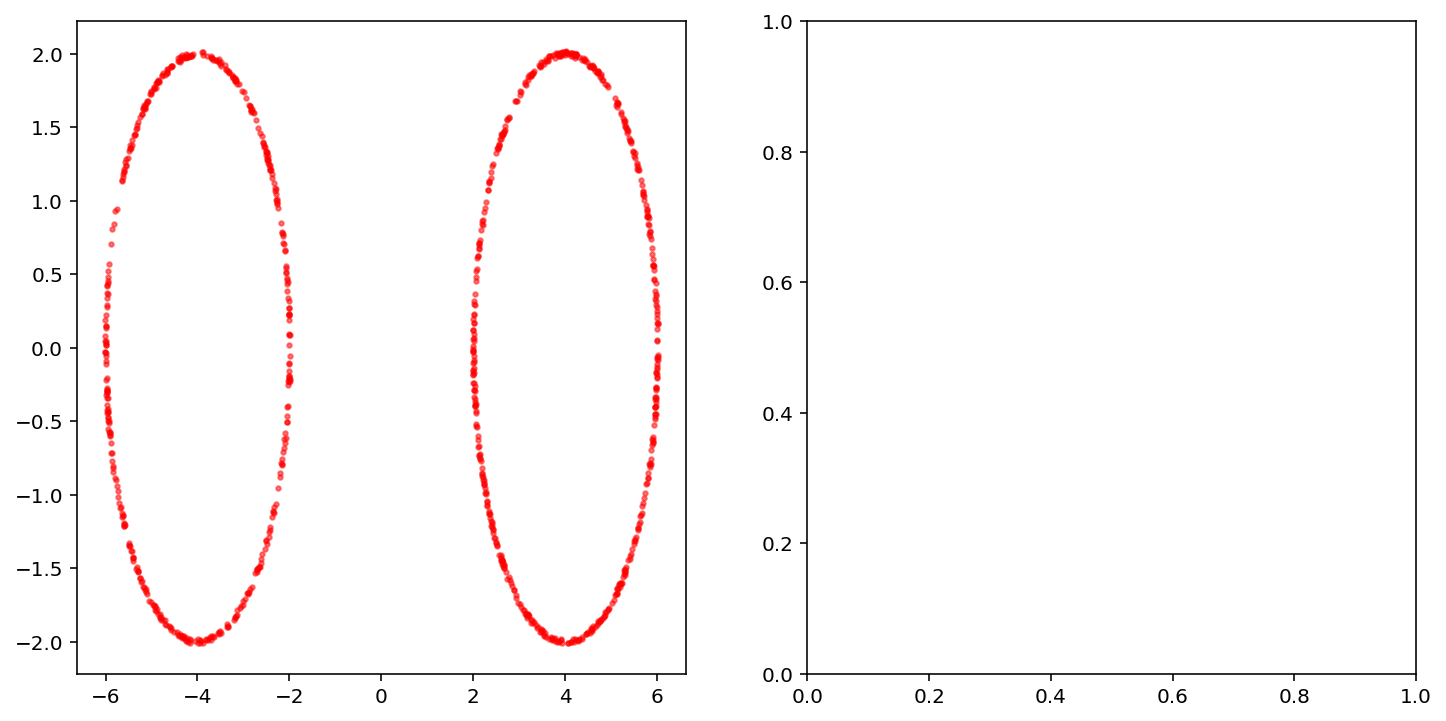

In [24]:
model = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
test(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedNVP(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
        (translate_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=2, bias=True)
      

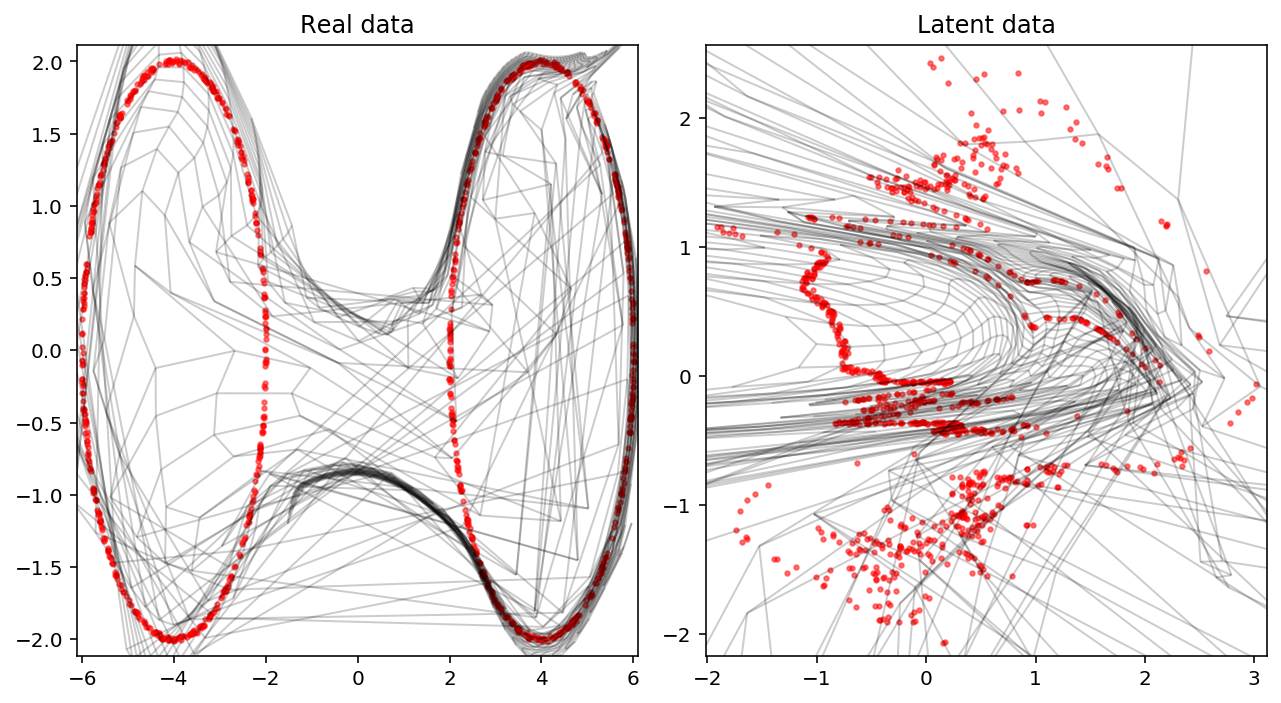

Creating directory for new run logs/test/run335
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
47.688


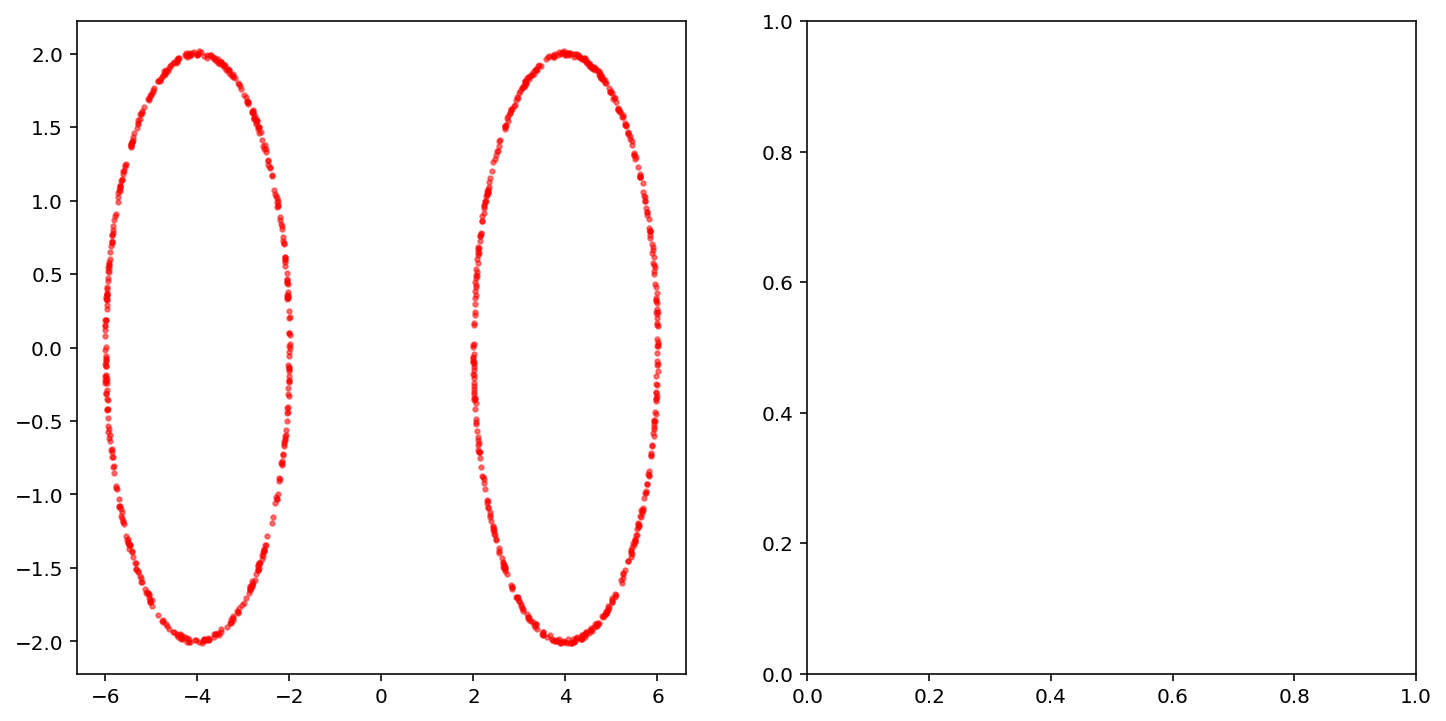

In [25]:
model = Trainer(like.x_dim, hidden_dim=64, num_blocks=5, flow='nvp', learning_rate=0.001)
test(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

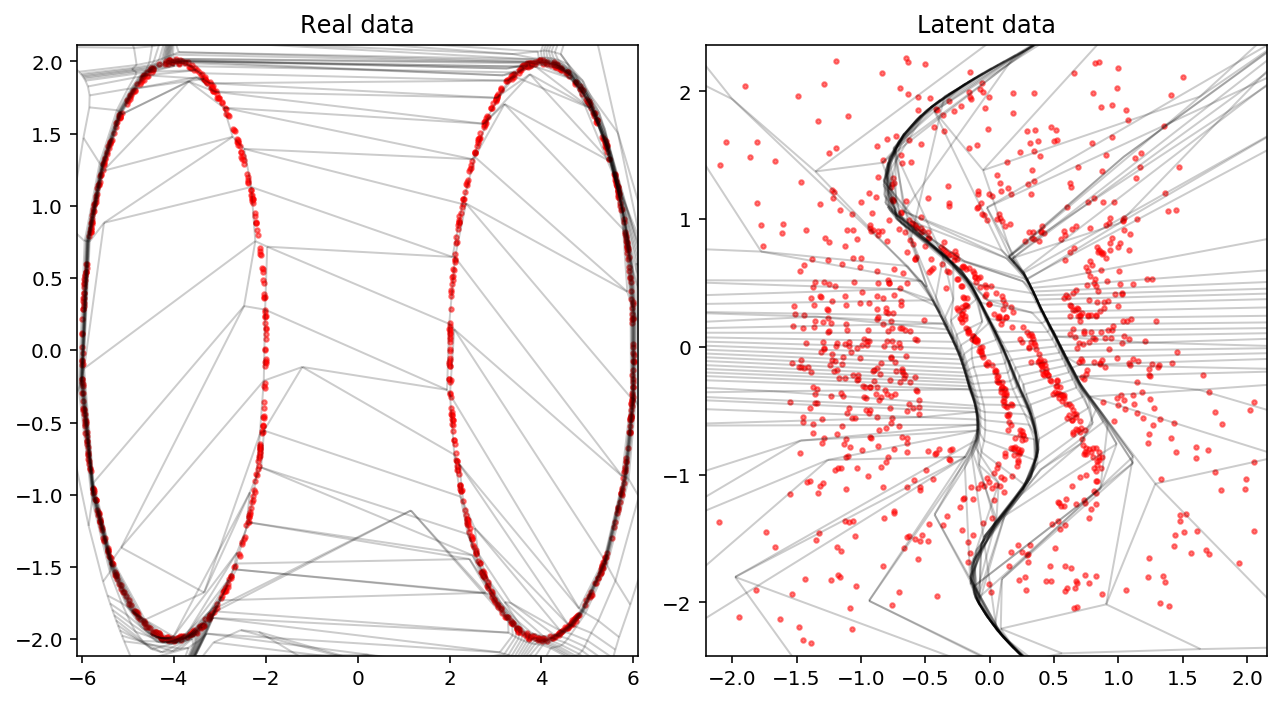

Creating directory for new run logs/test/run336
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
11.9


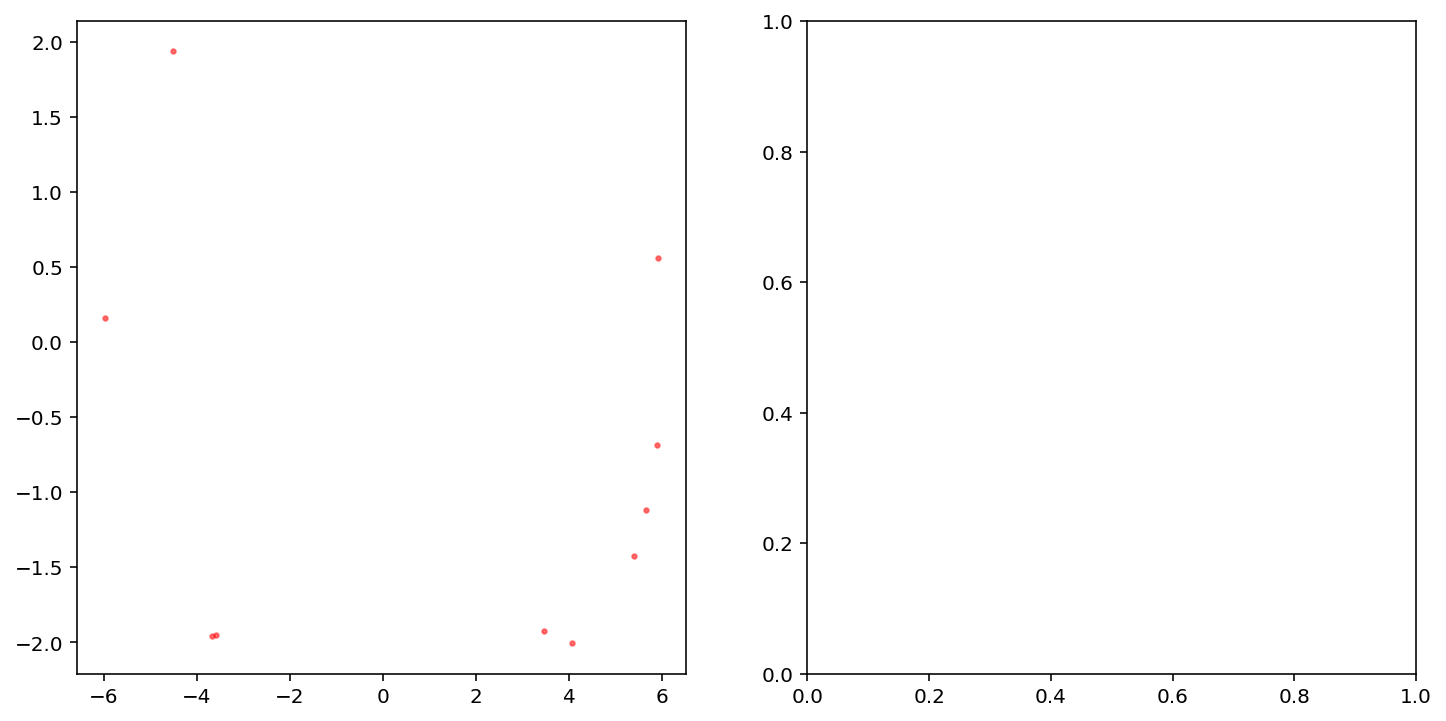

In [26]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test(like, prior, model, num_samples=10)